In [1]:
import sys
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import numdifftools as nd
import sympy as sy
import cv2
import math
import torchvision.transforms as T
import tensorflow as tf
from skimage import io
from PIL import Image, ImageOps
import warnings
import scipy.stats as ss 
import copy
sys.path.append("../../")

In [2]:
from pydens import Solver, D, V, ConvBlockModel
from pydens import NumpySampler as NS
from pydens import ScipySampler as SS
from pydens import Sampler

In [154]:
def plot_loss(loss):
    plt.plot(loss)
    plt.grid()
    plt.xlabel('Iteraciones', fontsize=16)
    plt.ylabel('Pérdida', fontsize=16)

In [4]:
def plot_approximation_1d(points, approximation, solution_function, savepath=None,
                          title=None, ylim=None):
    if isinstance(points, torch.Tensor):
        points = points.detach().numpy()
    if isinstance(approximation, torch.Tensor):
        approximation = approximation.detach().numpy()

    plt.plot(points, approximation, label='Neural Network approximation',
             linewidth=5, alpha=0.8)
    plt.plot(points, solution_function(points), label='Known analytical solution',
             linewidth=2)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$\hat{f}(x)$', fontsize=16)
    plt.grid()
    plt.legend(fontsize=12, loc=1)

    if ylim is not None:
        plt.ylim(ylim)

    if title is not None:
      plt.title(title, fontsize=16)

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

In [5]:
def plot_approximation_2d(approximation):
    plt.imshow(approximation)
    plt.colorbar()
    plt.title(r'$\hat{f}(x, y)$', fontsize=16)
    plt.xlabel(r'$x$', fontsize=16)
    plt.ylabel(r'$y$', fontsize=16)

In [143]:

def cart_prod(*arrs):
    grids = np.meshgrid(*arrs, indexing='ij')
    return np.stack(grids, axis=-1).reshape(-1, len(arrs))

In [144]:
def perona_malik(u,x,y,t):
    dudx = D(u,x)
    dudy = D(u,y)
    dudxx = D(dudx,x)
    dudyy = D(dudy,y)
    dudxy = D(dudy,x)
    dudyx = D(dudx,y)
    return D(u,t) - dudx*(-2/((10)**2))*torch.exp(-(torch.pow(dudx,2) - torch.pow(dudy,2))/((10)**2))*(dudx*dudxx + dudy*dudxy) + dudy*(-2/((10)**2))*torch.exp(-(torch.pow(dudx,2) + 
    torch.pow(dudy,2))/((10)**2))*(dudx*dudyx + dudy*dudyy) - torch.exp(-(torch.pow(dudx,2) + 
    torch.pow(dudy,2))/((10)**2))*(dudxx + dudyy)



# def perona_malik(u,x,y,t):
#     dudx = D(u,x)
#     dudy = D(u,y)
#     dudxx = D(D(u,x),x)
#     dudyy = D(D(u,y),y)
#     dudxy = D(D(u,y),x)
#     dudyx = D(D(u,x),y)
#     return dudx*(-2/((10)**2))*torch.exp(-(torch.pow(dudx,2) + torch.pow(dudy,2))/((10)**2))*(dudx*dudxx + dudy*dudxy) - dudy*(-2/((10)**2))*torch.exp(-(torch.pow(dudx,2) + 
#     torch.pow(dudy,2))/((10)**2))*(dudx*dudyx + dudy*dudyy) + torch.exp(-(torch.pow(dudx,2) + 
#     torch.pow(dudy,2))/((10)**2))*(dudxx + dudyy) - D(u,t)
    
    

In [212]:
def pm(u,x,y,t):
    dudx = D(u,x)
    dudy = D(u,y)
    dudt = D(u,t)
    gu = 1/(1+((torch.pow(dudx,2)+(torch.pow(dudy,2)))/(50)**2))
    mod_dx = dudx*gu
    mod_dy = dudy*gu
    div = D(mod_dx,x) +  D(mod_dy,y)
    div += gu*(D(dudx,x) + D(dudy,y))
    return  dudt - div

    # restriccion con respecto a la condicion inicial y frontera
    
    # TOL = 0.0001
    # C1 = 0
    # C2 = (1 - torch.sign(x - (TOL))) * (dudx * dudx ) #x = 0
    # C3 = (1 + torch.sign(x - (1 - TOL))) * (dudx  * dudx ) #x = last

    # C4 = (1 - torch.sign(y - (TOL))) * (dudy * dudy) #y = 0
    # C5 = (1 + torch.sign(y - (1 - TOL))) * (dudy* dudy) #y = last

    # Total_loss = C1 + C2 + C3 + C4 + C5 + L2
    return Total_loss
    # return L2

In [14]:
# def perona_malik(u,x,y,t):
#     return D(u,x)*((-1/50**2)*math.exp(-((D(u,x)**2) + 
#     (D(u,y)**2))/50**2)*2*(D(u,x)*D(D(u,x),x) + D(u,y)*D(D(u,x),y))) - D(u,y)*((-1/50**2)*math.exp(-((D(u,x)**2) + 
#     (D(u,y)**2))/50**2)*2*(D(u,x)*D(D(u,y),x) + D(u,y)*D(D(u,y),y))) + math.exp(-((D(u,x)**2) + 
#     (D(u,y)**2))/50**2)*(D(D(u,x),x) + D(D(u,y),y)) - D(u,t)

In [15]:
 # TOL = 0.0001
    # C1 = 0
    # C2 = (1 - torch.sign(x - (TOL))) * (dudx * dudx ) #x = 0
    # C3 = (1 + torch.sign(x - (1 - TOL))) * (dudx  * dudx ) #x = last

    # C4 = (1 - torch.sign(y - (TOL))) * (dudy * dudy) #y = 0
    # C5 = (1 + torch.sign(y - (1 - TOL))) * (dudy* dudy) #y = last

In [16]:
def initial_condition(x,y):
    res = torch.zeros(len(x))
    for i in range(len(x)):
        if len(x) == 1:
            res[i] = initial_img[int(x.item()),int(y.item())]
        else:
            res[i]=initial_img[int(x[i]),int(y[i])]
    return res

# def initial_condition(x,y):
#     res = torch.zeros(len(x))
#     for i in range(len(x)):
#         if len(x) == 1:
#             res[i] = img[int(x.item()),int(y.item())]
#         else:
#             res[i]=img[int(x[i]),int(y[i])]
#     return res

In [17]:
def constraint(u,x,y):
    return  ((50-y)*(-initial_img[0,0]*(50-x)/50 - x*initial_img[49,0])/50 + initial_condition(x,torch.zeros(len(x))))/50 + (y*(-(50-x)*initial_img[0,49])/50 - x*initial_img[49,49]/50 + initial_condition(x,torch.full((len(x),1),49)))/50 + (50-x)*initial_condition(torch.zeros(len(y)),y)/50 + x*initial_condition(torch.full((len(x),1),49),y)/50 - initial_condition(x,y)

In [18]:
# def constraint(u,x,y,t):
#     return (50 - y)*((50-x)*u(0,0,t)/50 + x*u(50,0,t)/50 - u(x,0,t))/50 + y*((50-x)*u(0,50,t)/50 + x*u(50,50,t)/50 - u(x,50,t))/50 + ((50-y)*(-u(0,0,0)*(50-x)/50 - x*u(50,0,0)/50 + u) + u(x,0,0))/50 + (y*(-(50-x)*u(0,50,0)/50) - x*u(50,50,0)/50 + u(x,50,0))/50 - (50-x)*u(0,y,t)/50 - (x*u(50,y,t))/50 + (50-x)*u(0,y,0)/50 + x*u(50,y,0)/50 + u(x,y,t) - u(x,y,0) + torch.tensor(initial_condition(x,y))

# return  (50-y)*(-initial_condition(0,0)*(50-x)/50 - x*initial_condition(50,0)/50 + initial_condition(x,0))/50 + (y*(-(50-x)*initial_condition(0,50)/50) - x*initial_condition(50,50)/50 + initial_condition(x,50))/50 + (50-x)*initial_condition(0,y)/50 + x*initial_condition(50,y)/50 + u - torch.tensor(initial_condition(x,y))

In [146]:

def f(x,y):
    z = (x - .5)**2 + (y - .5)**2
    for i in range(0,len(z)):
        if x[i]==0 or y[i]==0 or x[i]==1 or y[i]==1:
            z[i] = 0
            continue
        if z[i] <= 0.03:
            z[i] = 0.5
        else: z[i] = 1

    return z
# def f(x,y):
#     z = (x - 1)**2 + (y - 1.5)**2
#     for i in range(0,len(z)):
#         if z[i] <= 1:
#             z[i] = 0.5
#         else: z[i] = 1

#     return z


In [20]:


def f_ring(x,y):
    z = (x - .7)**2 + (y - .5)**2
    for i in range(0,len(z)):
        if x[i]==0 or y[i]==0 or x[i]==1 or y[i]==1:
            z[i] = 0
            continue
        if z[i] <= 0.2 and z[i]>=0.1:
            z[i] = 0.5
        else: z[i] = 1

    return z


[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


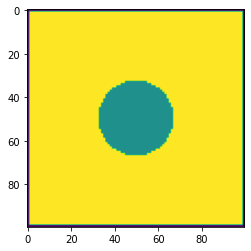

In [122]:
vals = np.linspace(0,1,100)
grid = cart_prod(vals,vals)
xs, ys = grid[:, 0:1], grid[:, 1:2]
# xx = np.linspace(0, 1, 200)
# yy = np.linspace(0, 1, 200)
# xs, ys = np.meshgrid(xx,yy)
cc = f(xs,ys).reshape(100,100)
print(cc)
plt.imshow(cc)
io.imsave('ring.jpg',cc)


In [222]:
solver_test1 = Solver(pm, ndims=3,boundary_condition=0,
initial_condition= lambda x,y: f(x,y),
model=ConvBlockModel, layout='fa '*5 + 'f', units=[50]*5+[1], activation='relu')

In [23]:
_solver = Solver(perona_malik, ndims=3, boundary_condition=0,
initial_condition= lambda x,y: f(x,y),
model=ConvBlockModel, layout='fafaf', units=[30,40,1], activation="relu")

# solver_test = Solver(perona_malik, ndims=3,boundary_condition=0,
# initial_condition= lambda x,y: f(x,y),
# model=ConvBlockModel, layout='faRfafafafa+f', units=[100,100,100,100,100,1], activation='Tanh', domain=[(0,128),(0,128),(0,100)])

In [123]:
# solver_test1 = Solver(pm, ndims=3,boundary_condition=0,
# initial_condition= lambda x,y: f(x,y),
# model=ConvBlockModel, layout='faRfafafa+f', units=[50,50,50,50,1], activation='relu',domain=[(0,1),(0,1),(0,1)])

In [25]:
print('fa'*8 + 'f')

fafafafafafafafaf


In [48]:
solver_test2 = Solver(pm, ndims=3,boundary_condition=0,
initial_condition= lambda x,y: f(x,y),
model=ConvBlockModel, layout='fa fa fa fa f', units=[10,30,30,10,1], activation='Tanh',domain=[(0,1),(0,1),(0,1)])

# solver_test2 = Solver(perona_malik, ndims=3,boundary_condition=0,
# initial_condition= lambda x,y: f(x,y),
# model=ConvBlockModel, layout='fafafafafafafafaf', units=[20,20,20,20,20,20,20,20,1], activation='Tanh',domain=[(0,1),(0,1),(0,1)])
#  constraints=lambda u,x,y,t: constraint(u,x,y)

In [27]:
solver_test3 = Solver(perona_malik, ndims=3,boundary_condition=0,
initial_condition= lambda x,y: f(x,y),
model=ConvBlockModel, layout='faRfafafa+f', units=[50,50,50,50,1], activation='relu',domain=[(-1,4),(-1,4),(0,1)])

In [28]:
solver_test5 = Solver(perona_malik, ndims=3,boundary_condition=0,
initial_condition= lambda x,y: f(x,y),
model=ConvBlockModel, layout='faRfafafa+f', units=[50,50,50,50,1], activation='relu',domain=[(0,1),(0,1),(0,1)])

# solver_test5 = Solver(perona_malik, ndims=3,boundary_condition=0,initial_condition= lambda x,y: f(x,y),
# model=ConvBlockModel, layout='faRfafafa+f', units=[50,50,50,50,1], activation='relu',domain=[(0,1),(0,1),(0,5)])

In [29]:
print("faR" + "fa"*9 + "+f")

faRfafafafafafafafafa+f


In [30]:
solver_test4 = Solver(perona_malik, ndims=3,boundary_condition=0,
initial_condition= lambda x,y: f(x,y),
model=ConvBlockModel, layout="faR" + "fa"*9 + "+f", units=[50]*10 + [1], activation='Tanh',domain=(0,1))

In [139]:

x_data, y_data, t_data = np.meshgrid(np.linspace(0.0, 1, 100), np.linspace(0.0, 1, 100) , np.linspace(0, 9, 10))

In [201]:

sampler2 =  NS('n',dim=3).truncate(1,0)
sampler1 = NS('u',dim=3,low=0,high=1)
# sampler1 =  NS('u', dim=1).apply(lambda m: x_data) 

# sampler1 =  NS('u', dim=2,low=0,high=1) & NS('u',dim=1,low=0,high=10).apply(lambda m: m.astype(int))

sampler3 =  NS('u',dim=1,low=0,high=10).apply(lambda m:[ np.linspace(0,9,10)])*10

sampler4 =  NS('u',dim=2,low=0,high=1) & NS('u',dim=1).apply(lambda m: [[np.random.uniform(0,10)]]*2500)



In [129]:
ns3 = NS('u', dim=2,low=0,high=1).truncate(1,0, expr=lambda m: np.sum(np.square(m), axis=1)) & NS('u',low=0,high=1)

[[0.07697956 0.17783712 0.52448422]
 [0.36686458 0.60781336 0.09642031]
 [0.57711105 0.3881998  0.70370351]
 ...
 [0.14438575 0.21401701 0.25328156]
 [0.33111401 0.74137859 0.27158534]
 [0.52800146 0.12917139 0.51700232]]


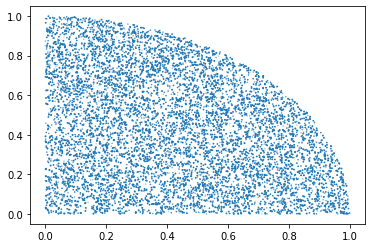

In [130]:

smp = ns3.sample(size=8000)
print(smp)
plt.scatter(*np.transpose(smp))

In [140]:
def reshape_and_concat(*tensors):
        """ Cast, reshape and concatenate sequence of incoming tensors. Returns `torch.Tensor`
        of size (N X D).
        Parameters
        ----------
        tensors : sequence
            Sequence of elements. Each element can be an numpy-array, `torch.Tensor` or a number.
            The function either casts or tiles and casts each array to a `torch.Tensor` of shape (N X 1).
        Returns
        -------
        torch.Tensor
            Tensor of shape (N X D), where D is defined as maximum length of tensor in the incoming
            sequence.
        """
        # Determine batch size as max-len of a tensor in included in the sequence.
        xs = list(tensors)
        sizes = ([np.prod(tensor.shape) for tensor in xs if isinstance(tensor, (np.ndarray, torch.Tensor))] +
                 [np.prod(np.array(tensor).shape) for tensor in xs if isinstance(tensor, (tuple, list))])
        batch_size = np.max(sizes) if len(sizes) > 0 else 1

        # Perform cast and reshape of all tensors in the list.
        for i, x in enumerate(xs):
            if isinstance(x, (int, float)):
                xs[i] = torch.Tensor(np.tile(x, (batch_size, 1))).float()
            if isinstance(x, np.ndarray):
                if x.size != batch_size:
                    x = np.tile(x.squeeze()[0], (batch_size, 1))
                xs[i] = torch.Tensor(x.reshape(batch_size, 1)).float()
            if isinstance(x, (list, tuple)):
                xs[i] = torch.Tensor(x).float().view(-1, 1)
            if isinstance(x, torch.Tensor):
                xs[i] = x.view(-1, 1)
        return torch.cat(xs, dim=1)

In [141]:
a = reshape_and_concat(x_data,y_data,t_data)
a = a.numpy()
print(a)


[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 2.]
 ...
 [1. 1. 7.]
 [1. 1. 8.]
 [1. 1. 9.]]


In [142]:
sampler1 =  NS('u', dim=1).apply(lambda m: a) 

[[0.78230773 0.81075396 0.75364023]
 [0.19433644 0.37826156 0.13920026]
 [0.50278117 0.17282328 0.41630868]
 ...
 [0.9361403  0.6226186  0.90297407]
 [0.04039835 0.41798684 0.84705245]
 [0.83387188 0.61631589 0.29781733]]


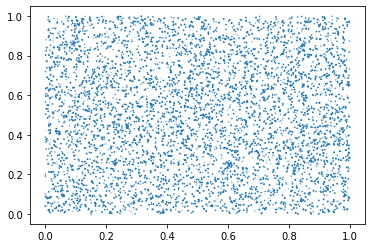

In [180]:
smp = sampler1.sample(size=5000)
print(smp)
plt.scatter(*np.transpose(smp))

In [219]:
solver_test1.fit(niters=100,batch_size=2500,sampler=sampler4, lr=0.01)

100%|██████████| 100/100 [02:26<00:00,  1.46s/it]


In [36]:
solver_test5.fit(niters=2000, batch_size=2500, lr=0.005, sampler=sampler4)

  0%|          | 0/2000 [00:00<?, ?it/s]


IndexError: tuple index out of range

In [ ]:
solver_test3.fit(niters=5000, batch_size=10000, lr=0.005, sampler=sampler3)

  0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 5000 and the array at index 1 has size 2500

In [52]:
solver_test2.fit(niters=100, batch_size=2500, lr=0.05, sampler=sampler2)
# loss_terms=('equation', 'constraint_0"

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [1063]:
solver_test4.fit(niters=3000, batch_size=2500, lr=0.001, sampler=sampler4)

100%|██████████| 3000/3000 [41:00<00:00,  1.22it/s] 


In [593]:
print(initial_img.shape)

(50, 50)


In [230]:
def get_prediction(xs,ys,t):
    return solver_test2.predict(xs,ys,t).reshape((50,50))

(64, 64)


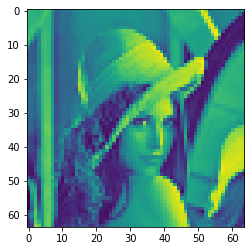

In [888]:
plt.imshow(initial_img)
print(initial_img.shape)

In [458]:
reverse_preprocess = T.Compose([
   T.Lambda(lambda t: (t + 1)/2),
   T.Lambda(lambda t: t.permute(1,2,0)),
   T.Lambda(lambda t: t* 255),
   T.Lambda(lambda t: t.numpy().astype(np.uint8)),
   T.ToPILImage()
])

In [195]:
vals = np.linspace(0,1,0)
grid = cart_prod(vals,vals)
xs, ys = grid[:, 0:1], grid[:, 1:2]
# xx = np.linspace(0, 1, 200)
# yy = np.linspace(0, 1, 200)
# xs, ys = np.meshgrid(xx,yy)
cc = f(xs,ys).reshape(50,50)
print(cc)
plt.imshow(cc)
io.imsave('tttt.jpg',cc)



ValueError: cannot reshape array of size 10000 into shape (50,50)

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.9999812  0.99996316 ... 0.99996316 0.9999812  0.        ]
 [0.         0.99996316 0.9999279  ... 0.9999279  0.99996316 0.        ]
 ...
 [0.         0.99996316 0.9999279  ... 0.9999279  0.99996316 0.        ]
 [0.         0.9999812  0.99996316 ... 0.99996316 0.9999812  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


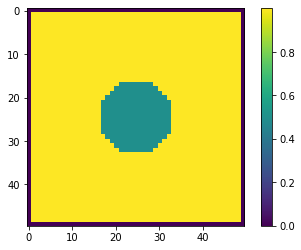

In [233]:
xx = np.linspace(0, 1, 50)
yy = np.linspace(0, 1, 50)
xs, ys = np.meshgrid(xx,yy)

a = get_prediction(xs,ys,100000000)
# reverse_preprocess(a)

print(a)
io.imsave("hope.jpg",a)
plt.imshow(a)
plt.colorbar()
plt.show()

In [1489]:
mat = np.subtract(cc,a)
print(mat)

0.0


In [62]:
vmin, vmax = -0.01, 0.63

def plot(t=.1):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))

    xs, ys = torch.tensor(grid[:, 0:1]).float(), torch.tensor(grid[:, 1:2]).float()
    ts = torch.full_like(xs, t)

    approxs = solver.model(xs, ys, ts)

    plt.imshow(approxs.reshape((100, 100)).detach().numpy(), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

In [64]:

def get_approxs(t=.1):
    grid = cart_prod(np.linspace(0, 1, 100),
                     np.linspace(0, 1, 100))

    xs, ys = torch.tensor(grid[:, 0:1]).float(), torch.tensor(grid[:, 1:2]).float()
    ts = torch.full_like(xs, t)

    return solver_test2.model(xs, ys, ts).reshape((100, 100)).detach().numpy()

In [65]:
# ts = [0, 0, 0, 0] + np.linspace(0, .25, 30).tolist()
# for i, t in enumerate(ts):
#     ar = get_approxs(t)
# approxs = get_approxs()
plot()

TypeError: forward() takes 2 positional arguments but 4 were given

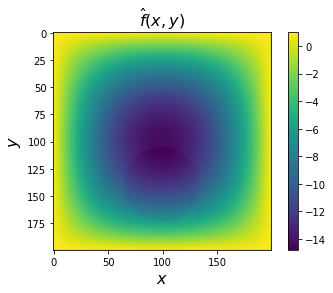

In [43]:
plot_approximation_2d(a)

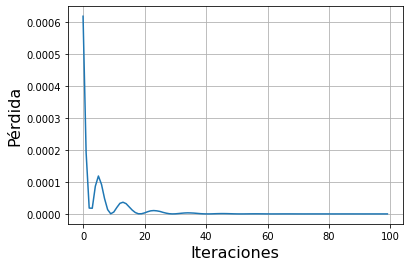

In [181]:
plot_loss(solver_test1.losses[:])


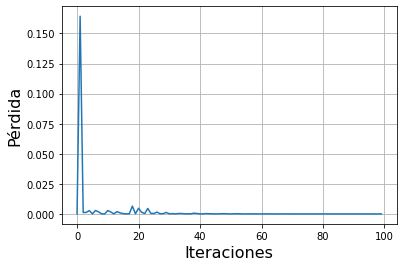

In [215]:
plot_loss(solver_test1.losses[:])

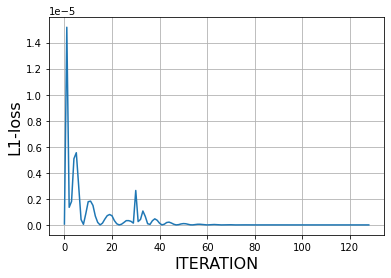

In [184]:
plot_loss(solver_test2.losses[:])

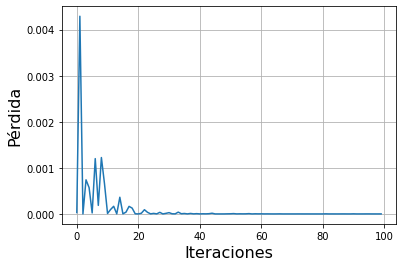

In [220]:
plot_loss(solver_test1.losses[:])

In [101]:
def get_predctn(t=0):
    xx = np.linspace(0, 3, 100)
    yy = np.linspace(0, 3, 100)
    xs, ys = np.meshgrid(xx,yy)
    
    return _solver.predict(xs, ys, t).reshape(100,100)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


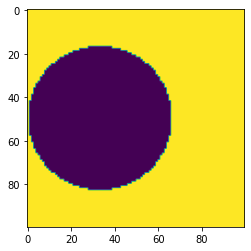

In [114]:
b = get_predctn()
b1 = get_predctn(1)
b2 = get_predctn(10)
print(b)

# b *= 255 # or any coefficient
# b = b.astype(np.uint8)
plt.imshow(b)



[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         0.9999998  0.9999997  ... 0.9997716  0.99976444 0.99975723]
 [1.         0.9999997  0.9999996  ... 0.9995437  0.99952924 0.99951464]
 ...
 [1.         1.0001876  1.0003414  ... 1.1164678  1.1205374  1.124694  ]
 [1.         1.0001967  1.0003583  ... 1.11988    1.124068   1.1283451 ]
 [1.         1.0002062  1.0003759  ... 1.1233418  1.1276493  1.1320484 ]]


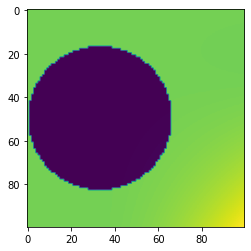

In [103]:
plt.imshow(b1)
print(b1)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


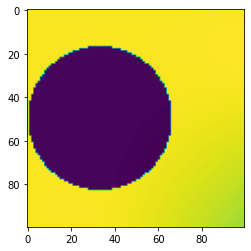

In [109]:
plt.imshow(b2)
print(b)